## 2. KNN

### References:
1. https://github.com/ypwhs/dogs_vs_cats
2. https://www.kaggle.com/yangpeiwen/keras-inception-xception-0-47

### Import pkgs

In [1]:
import cv2
import numpy as np
from tqdm import tqdm
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
# from keras.preprocessing import image
# from keras.models import Model
# from keras.layers import Dense, GlobalAveragePooling2D
# from keras import backend as K

# from keras.layers import Input
# from keras.layers.core import Lambda

# from keras.applications.vgg16 import VGG16
# from keras.applications.vgg19 import VGG19
# from keras.applications.resnet50 import ResNet50
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.xception import Xception
# from keras.applications.inception_resnet_v2 import InceptionResNetV2


from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *
from keras.regularizers import *
from keras.applications.inception_v3 import preprocess_input

### Load data

In [3]:
cwd = os.getcwd()
df = pd.read_csv(os.path.join(cwd, 'input', 'labels.csv'))
print('lables amount: %d' %len(df))
df.head()

lables amount: 10222


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
n = len(df)
breed = set(df['breed'])
n_class = len(breed)
class_to_num = dict(zip(breed, range(n_class)))
num_to_class = dict(zip(range(n_class), breed))

In [5]:
width = 299
X = np.zeros((n, width, width, 3), dtype=np.uint8)
y = np.zeros(n, dtype=np.uint8)
for i in tqdm(range(n)):
    X[i] = cv2.resize(cv2.imread('.\\input\\train\\%s.jpg' % df['id'][i]), (width, width))
    y[i] = class_to_num[df['breed'][i]]

100%|███████████████████████████████████| 10222/10222 [01:10<00:00, 144.26it/s]


### Preview images

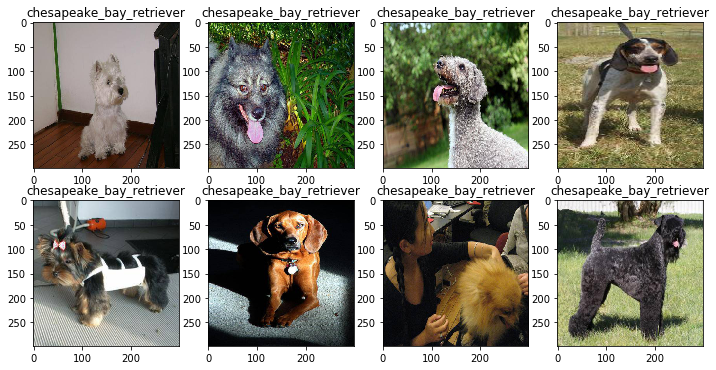

In [6]:
plt.figure(figsize=(12, 6))
for i in range(8):
    random_index = random.randint(0, n-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(X[random_index][:,:,::-1])
    plt.title(num_to_class[y[random_index].argmax()])
plt.show()

## Shulfe and split data

In [7]:
print(X.shape)
print(y.shape)
x_data = X.reshape(X.shape[0],-1)
print(x_data.shape)
print(y[0:10])

(10222, 299, 299, 3)
(10222,)
(10222, 268203)
[61 10 28 85 56  8  8  3 86  4]


In [8]:
from sklearn.utils import shuffle
x_data, y_data = shuffle(x_data, y)

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.05)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(9710, 268203)
(9710,)
(512, 268203)
(512,)


### Staticstic method

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

def my_GridSearchCV(model, parameters):
    if parameters:
        clf = GridSearchCV(model, parameters)
    else:
        clf = model
    clf.fit(x_train, y_train)
    return clf

def ny_train(models):
    clfs = {}
    for key, value in models.items():
        print('start ' + key)
        clf = my_GridSearchCV(value['model'], value['param'])
        clfs[key] = clf
    return clfs

def my_predict(clfs, x_val=x_val, y_val=y_val):
    for key, value in clfs.items():
        print(key, end=':  ')
        y_pred = value.predict(x_val)
        print(accuracy_score(y_val, y_pred))

In [15]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

models = {}
models = {
#     'SVC': {
#         'model': SVC(),
#         'param': {'kernel':('linear', 'rbf'), 'C':[1, 5, 10]}
#     },
#     'GaussianNB':{
#         'model': GaussianNB(),
#         'param': {}
#     },
#     'AdaBoostClassifier':{
#         'model': AdaBoostClassifier(),
#         'param': {}
#     },
#     'RandomForestClassifier':{
#         'model': RandomForestClassifier(),
#         'param': {}
#     },
    'KNeighborsClassifier':{
        'model': KNeighborsClassifier(n_neighbors=3),
        'param': {'n_neighbors':range(3, 7)}
    }
}

### Train model

In [ ]:
%%time
clfs = ny_train(models)
my_predict(clfs)

start KNeighborsClassifier


## Cross validation

In [ ]:
from sklearn.metrics import log_loss, accuracy_score
print('Val log_loss: {}'.format(log_loss(log_loss_y_val, val_proba)))
val_proba_limit = np.clip(log_loss_y_val, 0.005, 0.995)
print('Val log_loss: {}'.format(log_loss(log_loss_y_val, val_proba_limit)))
print('Val accuracy_score: {}'.format(accuracy_score(y_val, val_preds)))

### Load test data

In [ ]:
df2 = pd.read_csv('.\\input\\sample_submission.csv')
n_test = len(df2)
X_test = np.zeros((n_test, width, width, 3), dtype=np.uint8)
for i in tqdm(range(n_test)):
    X_test[i] = cv2.resize(cv2.imread('.\\input\\test\\%s.jpg' % df2['id'][i]), (width, width))

### Export test data feature

In [ ]:
inception_features = get_features(InceptionV3, X_test)
xception_features = get_features(Xception, X_test)
features_test = np.concatenate([inception_features, xception_features], axis=-1)

### Get test data prediction and output

In [ ]:
y_pred = model.predict(features_test, batch_size=128)
for b in breed:
    df2[b] = y_pred[:,class_to_num[b]]
df2.to_csv('.\\output\\pred.csv', index=None)

In [ ]:
print('Done !')